In [ ]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!unzip -qq dul_2021/Homework/hw1/data/hw1_data.zip -d dul_2021/Homework/hw1/data/
!mv -v dul_2021/Homework/hw1/data/hw1_data/* dul_2021/Homework/hw1/data/
!rmdir dul_2021/Homework/hw1/data/hw1_data/
!pip install ./dul_2021

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import IPython
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as opt
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
from torch.distributions.beta import Beta

import copy

from scipy.stats import norm
from scipy.optimize import bisect
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from dul_2021.utils.hw8_utils import *

# Question 1. KMM

## Notations from practice

*   $p_{nu}(x)$ - pdf of numerator
*   $p_{de}(x)$ - pdf of denominator
*   $r(x)=\frac{p_{nu}(x)}{p_{de}(x)}$ - density ratio
*   $p_{nu}^*, p_{du}^*, r^*$ - estimatinos of respective functions
*   $\{x^{nu}_i\}_{i=1}^{n_{nu}}$ - sample from numerator distribution
*   $\{x^{de}_i\}_{i=1}^{n_{de}}$ - sample from denominator distribution



## KMM objective

Here we will implement Kernel Mean Matching (KMM) method for density ratio estimation. The basic idea of KMM is to 'match' expections of kernel function:

$$argmin_{r^*} ||E_{p_{de}}r^*(x)K(\cdot, x) - E_{p_{nu}}K(\cdot, x)||$$

Where $K(x, x') = exp(-\frac{|x-y|^2}{2\sigma^2})$. Emperical variant of this objective can be rewritten as follows:

$$argmin_{r^*} \frac{1}{n_{de}^2} (r^*_{de})^t K_{de, de} r^*_{de} - \frac{2}{n_{nu}n_{de} }(r^*_{de})^t K_{de, nu}1_{n_{nu}}$$

Where


*   $r^*_{de}$ - vector with $(r^*_{de})_i=r^*(x^{de}_i)$
*   $K_{de, de}$ - matrix with $(K_{de, de})_{i, j} = K(x^{de}_i, x^{de}_j)$
*   $K_{de, nu}$ - matrix with $(K_{de, nu})_{i, j} = K(x^{de}_i, x^{nu}_j)$
*   $1_{n_{nu}}$ - vector with $n_{nu}$ ones


## You will provide these deliverables
Density ratio on $[-2, 2]$.


<Figure size 432x288 with 0 Axes>

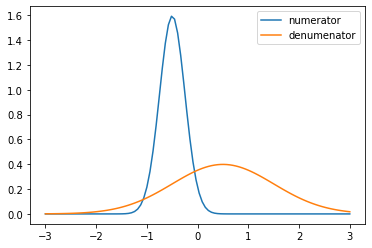

In [ ]:
# distributions

In [ ]:
class KMM(nn.Module):
    def __init__(self, hd=128, sigma=1):
        super().__init__()
        self.r = nn.Sequential(nn.Linear(1, hd), 
                               nn.ReLU(),
                               nn.Linear(hd, hd), 
                               nn.ReLU(),
                               nn.Linear(hd, 1),
                               nn.Softplus())
        self.sigma = sigma
        
    
    def fit(self, data_nu, data_de, batch_size=512, lr=1e-3, num_epochs=1000):
     
        loader_nu = data.DataLoader(data_nu, 
                                    batch_size=batch_size, 
                                    shuffle=True)
        
        loader_de = data.DataLoader(data_de, 
                                    batch_size=batch_size, 
                                    shuffle=True)
        

        optim = opt.Adam(self.r.parameters(), lr=lr)


        for epoch in tqdm(range(num_epochs)):
            for (batch_nu, batch_de) in zip(loader_nu, loader_de):
                batch_nu = batch_nu.view(-1, 1).float()
                batch_de = batch_de.view(-1, 1).float()

                n_de = batch_de.shape[0]
                n_nu = batch_nu.shape[0]
                
                r_de = self.r(batch_de)
                ones_nu = torch.ones(n_nu, 1)
                K_de_de = -torch.abs(batch_de - batch_de.T) ** 2
                K_de_de = torch.exp(K_de_de / (2 * self.sigma ** 2))
                K_de_nu = -torch.abs(batch_de - batch_nu.T) ** 2
                K_de_nu = torch.exp(K_de_nu / (2 * self.sigma ** 2))

                t1 = r_de.T @ K_de_de @ r_de / (n_de **2)
                t2 = 2 / (n_de * n_nu) * r_de.T @ K_de_nu @ ones_nu
                
                loss = t1 - t2


                optim.zero_grad()
                loss.backward()
                optim.step()

In [ ]:
def q1(data_nu, data_de):
  """
  data_nu - An [n_nu] dataset with samples from numerator's distribution
  data_de - An [n_de] dataset with samples from denominators's distribution
  
  Returns
    - a np.array with density ratios of np.linspace(-2., 2, num=100)
  """

  # you need to calculate density ratio on x and return it
  # x = np.linspace(-2., 2, num=100)

  model = KMM(sigma=0.1)
  model.fit(data_nu, data_de, num_epochs=300)
  x = torch.linspace(-2, 2, 100).view(-1, 1)
  rs = model.r(x)
  rs = rs.detach().numpy().reshape(-1)
  return rs


  0%|          | 0/300 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

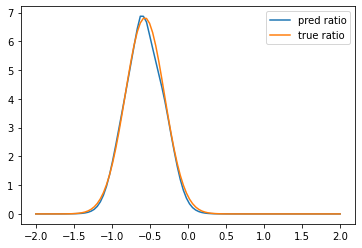

In [ ]:
q1_results(q1)

<Figure size 432x288 with 0 Axes>

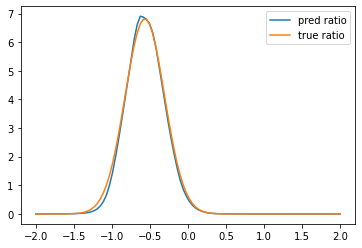

In [ ]:
q1_results(q1) # ref

# Question 2. AVB

Here we will implement [Adversairal Variational Bayes](https://dl.acm.org/doi/pdf/10.5555/3305890.3305928).

You may experiment with different hyperparameters and architecture designs, but the following designs for the AVB architecture may be useful.

```
Classifier (T)
    Conv2d(1, 32, 3, 1, 1), 
    ReLU(),
    Conv2d(32, 64, 3, 2, 1),
    ReLU(), 
    Conv2d(64, 128, 3, 2, 1), 
    ReLU(), 
    Conv2d(128, 128, 3, 2, 1), 
    ReLU(),
    # reshape + add latent
    Linear(4 * 4 * 128 + ld, hd), 
    ReLU(),
    Linear(hd, hd), 
    ReLU(),
    Linear(hd, 1)


Encoder (E)

    Conv2d(1, 32, 3, 1, 1), 
    ReLU(),
    Conv2d(32, 64, 3, 2, 1),
    ReLU(), 
    Conv2d(64, 128, 3, 2, 1), 
    ReLU(), 
    Conv2d(128, 128, 3, 2, 1), 
    ReLU(), 
    # add noise + reshape
    Linear(4 * 4 * 128 + nd, ld)

Decoder (D)
    ConvTranspose2d(128, 128, 3, 2, 1), 
    ReLU(), 
    ConvTranspose2d(128, 64, 4, 2, 1), 
    ReLU(), 
    ConvTranspose2d(64, 32, 4, 2, 1), 
    ReLU(), 
    Conv2d(32, 1, 3, 1, 1)
    # reshape
    Linear(ld, 4 * 4 * 128), 
    ReLU()
```

**Reminder.** Objective for AVB

$$max_{\theta, \phi} E \log p_\theta(x|z_\phi(x)) - T(x, z_\phi(x))$$
$$max_{T} E_x \bigg(E_{q_\phi(z|x)} \log\big(\sigma (T(x, z))\big) + E_{p(z)} \log\big(1 - \sigma (T(x, z))\big)\bigg) $$

$\phi$ - parameters of encoder, $\theta$ - parameters of decoder


**You will provide the following deliverables**


1.   Over the course of training, record the elbo and loss of the classifier T ber batch.
2. Report the final test set performances of your final models
3. 100 samples from your trained AVB

In [ ]:
from torch.distributions.normal import Normal

class Classifier(nn.Module):
    def __init__(self, ld=32, hd=32):
        super().__init__()

        self.part_1 = nn.Sequential(
                    nn.Conv2d(1, 32, 3, 1, 1), 
                    nn.ReLU(),
                    nn.Conv2d(32, 64, 3, 2, 1),
                    nn.ReLU(), 
                    nn.Conv2d(64, 128, 3, 2, 1), 
                    nn.ReLU(), 
                    nn.Conv2d(128, 128, 3, 2, 1), 
                    nn.ReLU(),
                )

        self.part_2 = nn.Sequential(
                    nn.Linear(4 * 4 * 128 + ld, hd), 
                    nn.ReLU(),
                    nn.Linear(hd, hd), 
                    nn.ReLU(),
                    nn.Linear(hd, 1)
                )

    def forward(self, x, z):
        out = self.part_1(x)
        out = out.view(-1, 4 * 4 * 128)
        out = torch.cat([out, z], dim=1)
        out = self.part_2(out)
        return out


class Encoder(nn.Module):
    def __init__(self, nd=32, ld=32):
        super().__init__()

        self.part_1 = nn.Sequential(
                        nn.Conv2d(1, 32, 3, 1, 1), 
                        nn.ReLU(),
                        nn.Conv2d(32, 64, 3, 2, 1),
                        nn.ReLU(), 
                        nn.Conv2d(64, 128, 3, 2, 1), 
                        nn.ReLU(), 
                        nn.Conv2d(128, 128, 3, 2, 1), 
                        nn.ReLU(), 
                )

        self.part_2 = nn.Linear(4 * 4 * 128 + nd, ld)

        self.noise_distr = Normal(torch.tensor([0.0]).to(device), 
                                  torch.tensor([1.0]).to(device))
        self.nd = nd

    def forward(self, x):
        bs = x.shape[0]
        out1 = self.part_1(x)
        out2 = out1.view(-1, 4 * 4 * 128)
        z = self.noise_distr.sample((bs, self.nd)).squeeze()
        out2 = torch.cat([out2, z], dim=1)
        out2 = self.part_2(out2)
        return out2


class Decoder(nn.Module):
    def __init__(self, ld=32):
        super().__init__()

        self.part_1 = nn.Sequential(
                        nn.Linear(ld, 4 * 4 * 128), 
                        nn.ReLU()
                )
        
        self.part_2 = nn.Sequential(
                            nn.ConvTranspose2d(128, 128, 3, 2, 1), 
                            nn.ReLU(), 
                            nn.ConvTranspose2d(128, 64, 4, 2, 1), 
                            nn.ReLU(), 
                            nn.ConvTranspose2d(64, 32, 4, 2, 1), 
                            nn.ReLU(), 
                            nn.Conv2d(32, 1, 3, 1, 1)
                            )

    def forward(self, x):
        out = self.part_1(x)
        out = out.view(-1, 128, 4, 4)
        out = self.part_2(out)
        return out

class prior_z(nn.Module):
    def __init__(self, ld=32):
        super().__init__()

        self.distr = Normal(torch.tensor([0.0]).to(device), 
                            torch.tensor([1.0]).to(device))
        self.ld = ld

    def sample(self, bs):
        z = self.distr.sample((bs, self.ld)).squeeze()
        return z


class AVB(nn.Module):
    def __init__(self, nd=32, ld=32, hd=32):
        super().__init__()

        self.T = Classifier(ld=ld, hd=hd) # D
        self.E = Encoder(nd=nd, ld=ld)    # q(z|x)
        self.D = Decoder(ld=ld)           # p(x|z)
        self.pz = prior_z(ld=ld)          # p(z)


    def dis_loss(self, x):
        fake_z = self.E(x)
        t1 = (1 - self.T(x, fake_z).sigmoid()).log()

        real_z = self.pz.sample(x.shape[0])
        t2 = self.T(x, real_z).sigmoid().log()

        loss = -(t1 + t2)
        return loss.mean()


    def gen_loss(self, x):
        fake_z = self.E(x)
        t1 = (x - self.D(fake_z)) ** 2
        t1 = t1.reshape(x.shape[0], -1).sum(dim=-1) # mean

        t2 = self.T(x, fake_z).reshape(-1)
        t2 = (1 - t2.sigmoid()) / t2.sigmoid() # D*

        loss = t1 + t2.log()
        return loss.mean()


    def test(self, test_dataloader):
        with torch.no_grad():
            test_loss_D = []
            test_loss_G = []

            for i, r_batch in enumerate(test_dataloader):
                r_batch = r_batch.float().to(device)

                loss = self.dis_loss(r_batch)
                test_loss_D.append(loss.item())

                
                loss = self.gen_loss(r_batch)
                test_loss_G.append(loss.item())
                        
        return np.mean(test_loss_G), np.mean(test_loss_D)


    def fit(self, train_data, test_data, n_critic=1, lr=1e-3, num_epochs=100, 
            bs=128, betas=(0.9, 0.999)):
        trainloader = data.DataLoader(train_data,
                                      batch_size=bs, 
                                      shuffle=True)
        
        testloader = torch.utils.data.DataLoader(test_data, 
                                                 batch_size=bs)

        gen_opt = opt.Adam(list(self.E.parameters()) + list(self.D.parameters()), lr=lr, betas=betas)
        dis_opt = opt.Adam(self.T.parameters(), lr=lr, betas=betas)

        
        train_loss_D = []
        train_loss_G = []

        test_loss_D = []
        test_loss_G = []
        tlg, tld = self.test(testloader)
        test_loss_G.append(tlg)
        test_loss_D.append(tld)
        
        for epoch in tqdm(range(num_epochs)):
            t_losses_D = []
            t_losses_G = []

            for i, r_batch in enumerate(tqdm(trainloader)):
                r_batch = r_batch.float().to(device)

                # обновляем дискриминатор
                loss = self.dis_loss(r_batch)
                dis_opt.zero_grad()
                loss.backward()
                dis_opt.step()
                    
                cur_loss = loss.item()
                train_loss_D.append(cur_loss)
                t_losses_D.append(cur_loss)

                if i % n_critic == 0:
                    # обновляем генератор на каждом n_critic-м шаге
                    loss = self.gen_loss(r_batch)
                    gen_opt.zero_grad()
                    loss.backward()
                    gen_opt.step()

                    cur_loss = loss.item()
                    train_loss_G.append(cur_loss)
                    t_losses_G.append(cur_loss)

            print(f'Epoch {epoch + 1}: classifier_loss= {np.mean(t_losses_D):.5f},  elbo= {np.mean(t_losses_G):.5f}')
            tlg, tld = self.test(testloader)
            test_loss_G.append(tlg)
            test_loss_D.append(tld)

        return np.array(train_loss_G), np.array(train_loss_D), np.array(test_loss_G), np.array(test_loss_D)


    def sample(self, n_samples=100):
        with torch.no_grad():
            z = self.pz.sample(100)
            x = self.D(z) # [100, 1, 28, 28]
        return x.tanh()

In [ ]:
def q2(train_data, test_data):
    """
    train_data - A (n_train, 28, 28, 1) uint8 numpy array of binary images with values in {0, 1}
     Returns
    - a (# of training iterations,) numpy array of elbo_losses evaluated every minibatch
    - a (# of training iterations,) numpy array of classifier_losses evaluated every minibatch
    - a torch tensor of size (100, 1, 28, 28) of samples with values in {0, 1}
    """

    train_data = (torch.Tensor(train_data.transpose(0, 3, 1, 2)) - 0.5) / 0.5
    test_data = (torch.Tensor(test_data.transpose(0, 3, 1, 2)) - 0.5) / 0.5
    
    model = AVB()
    model.to(device)
    tr_l1, tr_l2, te_l1, te_l2 = model.fit(train_data, test_data, num_epochs=20, bs=256)
    samples = model.sample().cpu()
    samples = (samples * 0.5 + 0.5)

    return tr_l1, tr_l2, te_l1, te_l2, samples

  

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1: classifier_loss= 0.38600,  elbo= 276.22483


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2: classifier_loss= 0.46385,  elbo= 102.94850


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3: classifier_loss= 0.10093,  elbo= 66.49194


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4: classifier_loss= 0.03092,  elbo= 56.09140


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5: classifier_loss= 0.02959,  elbo= 49.91923


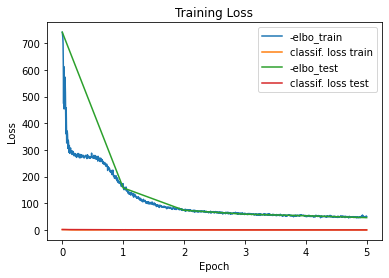

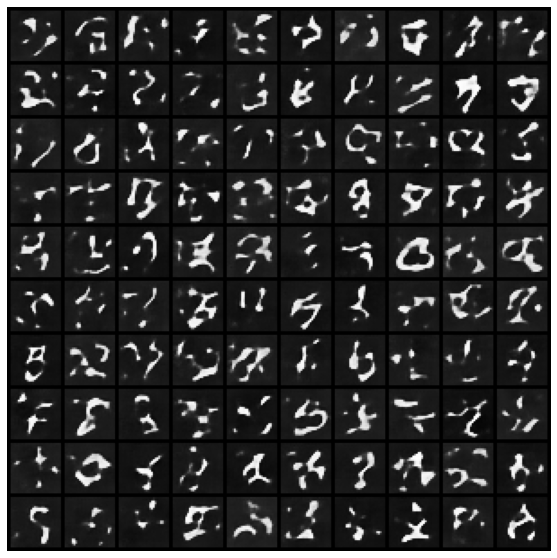

In [ ]:
q2_results(q2) # 5 ep

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1: classifier_loss= 0.58878,  elbo= 351.58605


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2: classifier_loss= 0.32586,  elbo= 148.72341


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3: classifier_loss= 0.04021,  elbo= 87.49242


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4: classifier_loss= 0.02802,  elbo= 70.59497


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5: classifier_loss= 0.02986,  elbo= 62.44428


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6: classifier_loss= 0.03462,  elbo= 57.68646


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7: classifier_loss= 0.03342,  elbo= 54.34150


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8: classifier_loss= 0.03033,  elbo= 51.93320


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9: classifier_loss= 0.04453,  elbo= 50.36261


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10: classifier_loss= 0.03327,  elbo= 48.66133


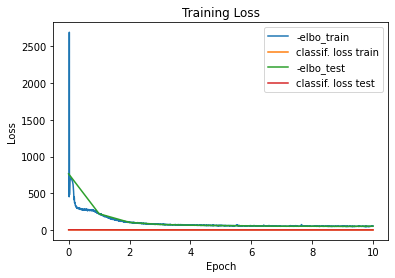

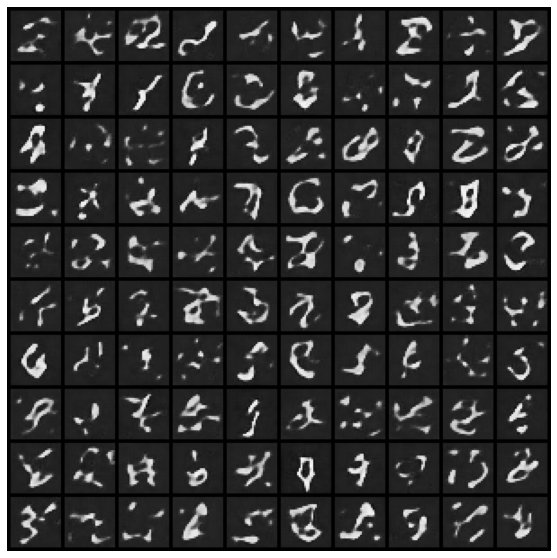

In [ ]:
q2_results(q2) # 10 ep

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1: classifier_loss= 0.63343,  elbo= 341.01267


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2: classifier_loss= 0.33681,  elbo= 117.30715


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3: classifier_loss= 0.06639,  elbo= 74.32344


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4: classifier_loss= 0.04148,  elbo= 62.61577


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5: classifier_loss= 0.03567,  elbo= 56.91921


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6: classifier_loss= 0.03648,  elbo= 53.62598


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7: classifier_loss= 0.03724,  elbo= 52.07416


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8: classifier_loss= 0.04582,  elbo= 49.92156


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9: classifier_loss= 0.03398,  elbo= 49.25526


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10: classifier_loss= 0.03734,  elbo= 47.20805


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11: classifier_loss= 0.03204,  elbo= 45.82701


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12: classifier_loss= 0.03492,  elbo= 44.84836


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13: classifier_loss= 0.03039,  elbo= 43.34110


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14: classifier_loss= 0.05425,  elbo= 46.00340


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15: classifier_loss= 0.03669,  elbo= 40.03802


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16: classifier_loss= 0.03861,  elbo= 42.49762


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17: classifier_loss= 0.03455,  elbo= 42.07016


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18: classifier_loss= 0.04330,  elbo= 42.06949


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19: classifier_loss= 0.04728,  elbo= 42.55608


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 20: classifier_loss= 0.05208,  elbo= 42.12773


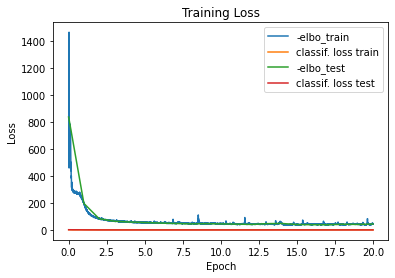

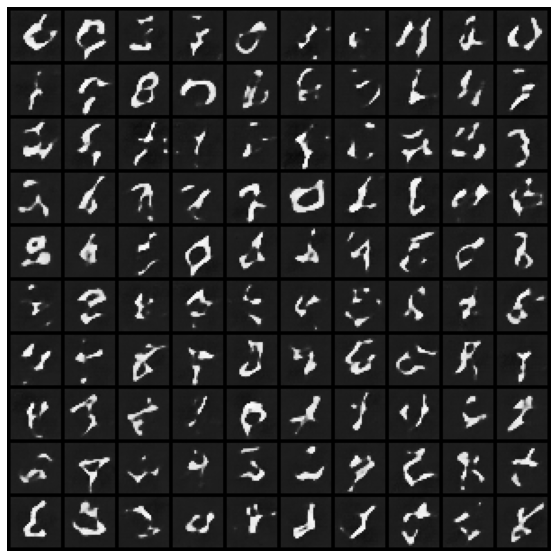

In [ ]:
q2_results(q2) # 20 ep

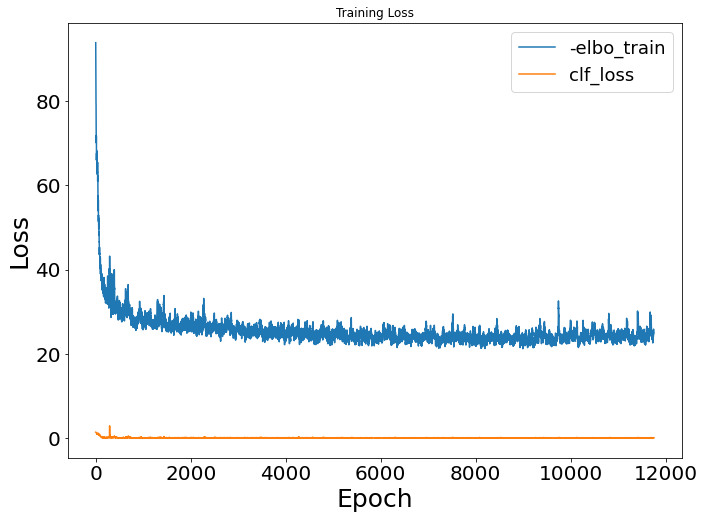

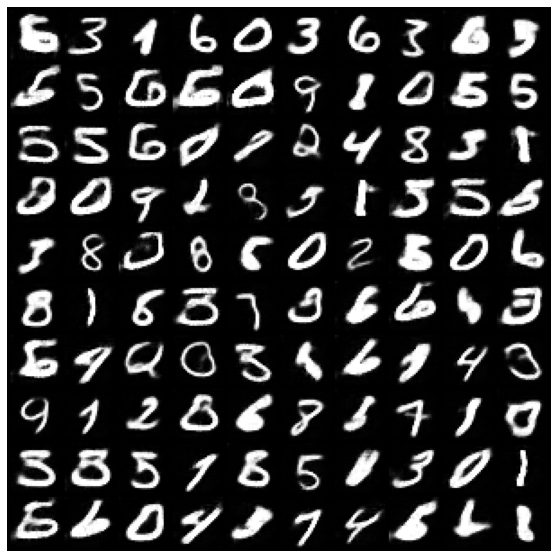

In [ ]:
q2_results(q2) # ref